In [105]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import torch
import torchvision as tv
from torch.utils.data import random_split, DataLoader, TensorDataset

import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger(project='ex3_video_classification')



In [75]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
455,v_ShavingBeard_g22_c06.avi,ShavingBeard
350,v_Punch_g24_c06.avi,Punch
427,v_ShavingBeard_g18_c06.avi,ShavingBeard
84,v_CricketShot_g20_c06.avi,CricketShot
91,v_CricketShot_g21_c06.avi,CricketShot
43,v_CricketShot_g14_c02.avi,CricketShot
479,v_TennisSwing_g08_c03.avi,TennisSwing
55,v_CricketShot_g15_c07.avi,CricketShot
573,v_TennisSwing_g22_c04.avi,TennisSwing
330,v_Punch_g21_c07.avi,Punch


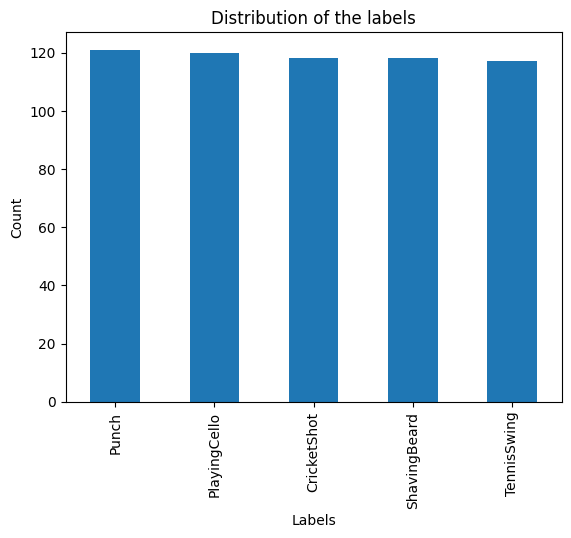

In [76]:
## make a histogram of the data
train_df['tag'].value_counts().plot(kind='bar')
plt.title('Distribution of the labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()


In [114]:

def load_videos_to_tensor(folder_path, frame_height, frame_width):
    videos = []
    
    # List all files in the directory
    video_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.avi')])
    
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        cap = cv2.VideoCapture(video_path)
        frames = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (frame_width, frame_height))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        
        cap.release()
        if len(frames) > 0:
            videos.append(frames)
    
    # Convert the list of frames to tensors
    video_tensors = [torch.tensor(np.array(video), dtype=torch.float32).permute(0, 3, 1, 2) for video in videos]

    # trim videos to the same length Using min criteria
    min_length = min([video.shape[0] for video in video_tensors])
    video_tensors = [video[:min_length] for video in video_tensors]

    # Stack the video tensors to create a single tensor
    video_tensor = torch.stack(video_tensors)
    
    return video_tensor

class VideoDataset(pl.LightningDataModule):
    def __init__(self, batch_size=32, frame_height=64, frame_width=64):
        super().__init__()
        self.data_dir = "data"
        self.batch_size = batch_size
        self.frame_height = frame_height
        self.frame_width = frame_width

    def setup(self, stage=None):
         # Read the CSV files
        train_df = pd.read_csv(os.path.join(self.data_dir, "train.csv"))
        test_df = pd.read_csv(os.path.join(self.data_dir, "test.csv"))

        # Read name as label for each video float 32 and Tensor
        self.labels = train_df['tag'].values
        self.label_map = {label: i for i, label in enumerate(np.unique(self.labels))}
        self.labels = torch.tensor([self.label_map[label] for label in self.labels])
        
        # Load the videos
        full_dataset = load_videos_to_tensor(os.path.join(self.data_dir, "train"), self.frame_width, self.frame_height)
        full_dataset = TensorDataset(full_dataset, self.labels)

        self.train_dataset, self.val_dataset = random_split(full_dataset, [0.9, 0.1])
        self.test_dataset = load_videos_to_tensor(os.path.join(self.data_dir, "test"), self.frame_width, self.frame_height)

    def train_dataloader(self):
        # include data and labels
        # return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(self.train_dataset, self.labels), batch_size=self.batch_size, shuffle=True, num_workers=4)
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
    

# # Create the dataset
dataset = VideoDataset(batch_size=4, frame_height=64, frame_width=64)
dataset.setup()
trainloader = dataset.train_dataloader()
valloader = dataset.val_dataloader()
testloader = dataset.test_dataloader()


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [110]:
# load a CnnLstm model
import torch.nn as nn

class CnnLstm(pl.LightningModule):

    def __init__(self, frame_height, frame_width, hidden_dim=256, num_layers=1):
        super().__init__()
        num_classes = 5
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.frame_height = frame_height
        self.frame_width = frame_width


        cnn = tv.models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(cnn.children())[:-2])  # Remove the final layers
        for param in self.cnn.parameters():
            param.requires_grad = False
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)



    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        cnn_features = []

        for t in range(seq_length):
            with torch.no_grad():
                cnn_out = self.cnn(x[:, t, :, :, :])
                cnn_out = cnn_out.view(batch_size, -1)
            cnn_features.append(cnn_out)
        cnn_features = torch.stack(cnn_features, dim=1)

        lstm_out, _ = self.lstm(cnn_features, (h0, c0))

        out = self.fc(lstm_out[:, -1, :])
        out = torch.nn.functional.log_softmax(out, dim=1)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
model = CnnLstm(frame_height=64, frame_width=64)
# model.forward(torch.randn(32, 44, 3, 64, 64))

/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [116]:
## train the model
wandb.finish()
wandb.init(project='ex3_video_classification',
            name='first run', 
            notes='resnet18 as backbone, 1 lstm layer, 256 hidden dim, 10 epochs',)


trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)
trainer.fit(model, trainloader, valloader)


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


KeyboardInterrupt: 